In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l


def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 代码几乎与d2l.train_ch6定义在卷积神经网络一章LeNet一节中的相同
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss,train_acc,num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # UsingPyTorchIn-Builtscheduler
                scheduler.step()
            else:
                # Usingcustomdefinedscheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

train loss 0.144, train acc 0.945, test acc 0.895


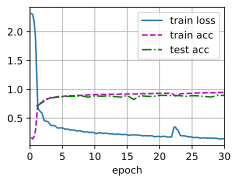

In [2]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## 学习率调度器 

In [3]:
lr = 0.1
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


In [4]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

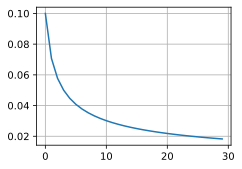

In [5]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.284, train acc 0.896, test acc 0.875


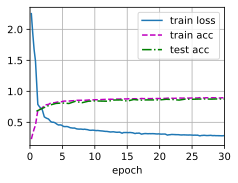

In [6]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

## 策略

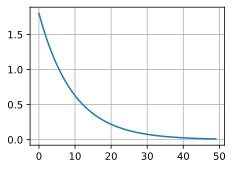

In [7]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

## 内置调度器

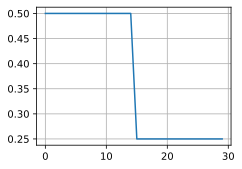

In [8]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
                                  for t in range(num_epochs)])

train loss 0.202, train acc 0.923, test acc 0.855


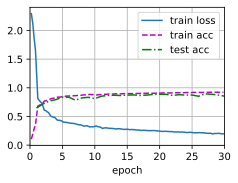

In [9]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

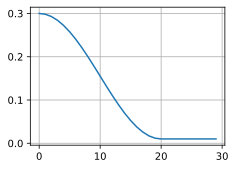

In [10]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.173, train acc 0.936, test acc 0.901


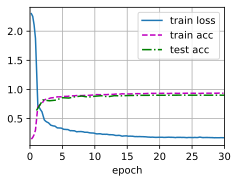

In [11]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

## 预热

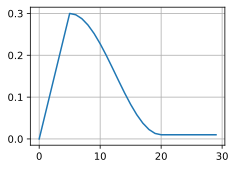

In [12]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.202, train acc 0.926, test acc 0.899


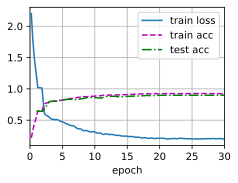

In [13]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)